In [1]:
from src.libs.lib import *
import pandas as pd
import matplotlib.pyplot as plt
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df_original = pd.read_csv("src/data/df_original.csv")
df_original = df_original.loc[:, ~df_original.columns.str.contains('^Unnamed')] 

# df_original = df_original.loc[df_original.nivel_px != 'Bronze']

df_original = pd.read_csv("src/data/df_original.csv")
df_original = df_original.loc[:, ~df_original.columns.str.contains('^Unnamed')] 
df_original['ano_mes'] = pd.to_datetime(df_original['ano_mes'])


df_comparativo = pd.read_csv("src/data/df_comparativo.csv")
df_comparativo = df_comparativo.loc[:, ~df_comparativo.columns.str.contains('^Unnamed')] 
df_comparativo['ano_mes'] = pd.to_datetime(df_comparativo['ano_mes'])
#2.6s

Hash numérica de 5 dígitos: 94799


In [2]:
meses_filtrados = [
    '2025-03-01 00:00:00', 
    '2025-02-01 00:00:00', 
    '2025-01-01 00:00:00',
    '2024-12-01 00:00:00', 
    '2024-11-01 00:00:00'
]


# Filtrar o DataFrame
df_original = df_original[df_original['ano_mes'].isin(pd.to_datetime(meses_filtrados))]
df_comparativo = df_comparativo[df_comparativo['ano_mes'].isin(pd.to_datetime(meses_filtrados))]

In [3]:
df_original.head()

,ano_mes,freight_id,tipo,nivel_px,dias_reducao
0,2025-03-01,154390,Diária,Prata,1.0
1,2025-03-01,154389,Diária,Prata,1.0
2,2025-03-01,154339,Diária,Prata,2.0
3,2025-03-01,154324,Coleta/Entrega,Bronze,1.0
4,2025-03-01,154314,Diária,Diamante,2.0


In [4]:
df_original.count()

ano_mes         2013
freight_id      2013
tipo            2013
nivel_px        2013
dias_reducao    2013
dtype: int64

In [5]:
# Calcular limites usando IQR 
q1 = df_original['dias_reducao'].quantile(0.25)
q3 = df_original['dias_reducao'].quantile(0.75)
iqr = q3 - q1

limite_inferior = q1 - 2 * iqr
limite_superior = q3 + 2 * iqr

# Filtrar dados sem outliers
df_original = df_original[
    (df_original['dias_reducao'] >= limite_inferior) &
    (df_original['dias_reducao'] <= limite_superior)
]


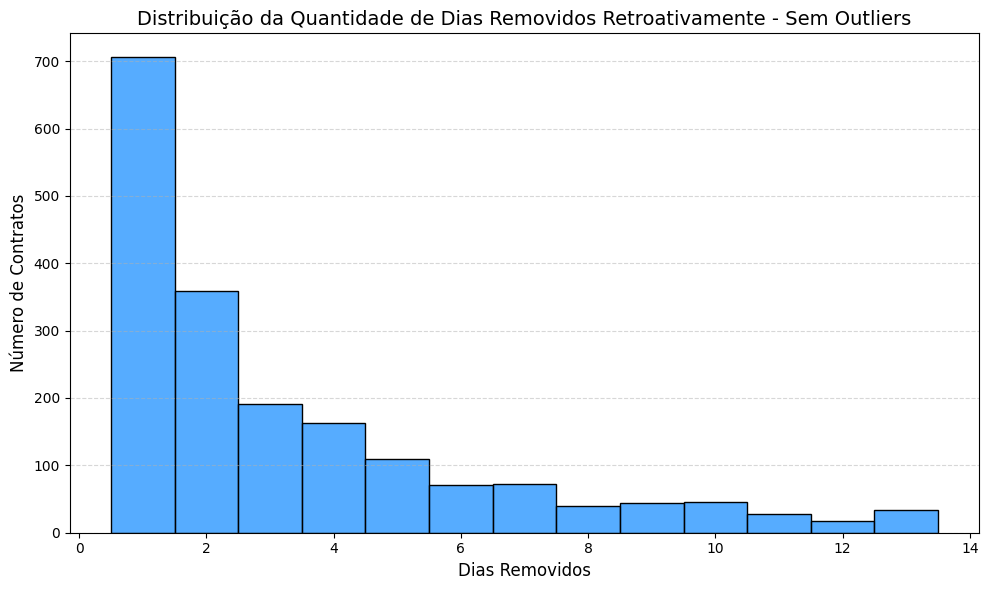

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 6))

# Cria bins com passo 1 em float, começando do mínimo ao máximo
min_val = df_original['dias_reducao'].min()
max_val = df_original['dias_reducao'].max()
bins = np.arange(min_val, max_val + 1, 1)

sns.histplot(
    df_original['dias_reducao'],
    bins=bins,
    kde=False,
    color='dodgerblue',
    edgecolor='black'
)

# Título e eixos
plt.title('Distribuição da Quantidade de Dias Removidos Retroativamente - Sem Outliers', fontsize=14)
plt.xlabel('Dias Removidos', fontsize=12)
plt.ylabel('Número de Contratos', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [7]:
df_original.dias_reducao.describe()

count    1879.000000
mean        3.242682
std         3.011412
min         0.500000
25%         1.000000
50%         2.000000
75%         4.000000
max        13.000000
Name: dias_reducao, dtype: float64

In [8]:
# 1. Separado por tipo de contrato, quantos tiveram remoção de dias retroativos?

# Agrupar por tipo e mês
remocoes_mensais = (
    df_original
    .groupby(['ano_mes', 'tipo'])
    .size()
    .reset_index(name='qtd_mensal')
)

# Calcular média mensal por tipo (como número inteiro)
media_mensal_por_tipo = (
    remocoes_mensais
    .groupby('tipo')['qtd_mensal']
    .mean()
    .round(0)
    .astype(int)
    .reset_index(name='media_mensal_remocoes')
)

media_mensal_por_tipo

,tipo,media_mensal_remocoes
0,Ajudante,2
1,Coleta/Entrega,65
2,Diária,309


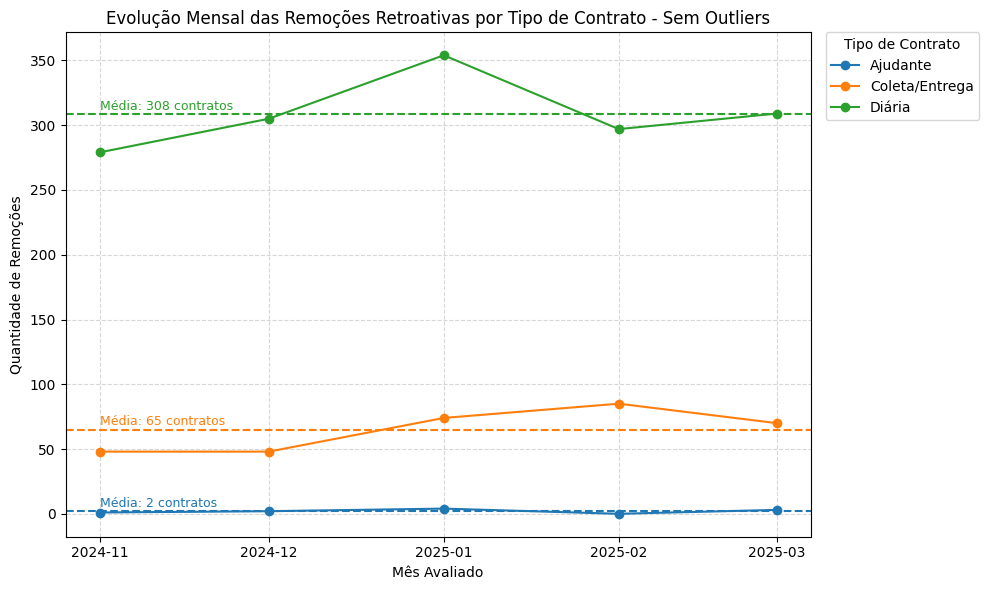

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

serie_mensal = remocoes_mensais.pivot(index='ano_mes', columns='tipo', values='qtd_mensal').fillna(0)
serie_mensal.index = serie_mensal.index.to_period('M').to_timestamp()

# Cores padrão por tipo
cores = {
    'Ajudante': 'tab:blue',
    'Coleta/Entrega': 'tab:orange',
    'Diária': 'tab:green'
}

plt.figure(figsize=(10, 6))

for tipo in serie_mensal.columns:
    # Linha de evolução
    plt.plot(serie_mensal.index, serie_mensal[tipo], marker='o', label=tipo, color=cores[tipo])
    
    # Média
    media = serie_mensal[tipo].mean()
    plt.axhline(y=media, linestyle='--', linewidth=1.5, color=cores[tipo])
    
    # Valor da média ao lado direito
    primeira_data = serie_mensal.index.min()
    plt.text(primeira_data, media + 1, f'Média: {int(media)} contratos', color=cores[tipo], va='bottom', ha='left', fontsize=9)

# Estética
plt.title('Evolução Mensal das Remoções Retroativas por Tipo de Contrato - Sem Outliers')
plt.xlabel('Mês Avaliado')
plt.ylabel('Quantidade de Remoções')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Nível PX')

# Formatar eixo X para mês/ano
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=0)

plt.legend(title='Tipo de Contrato', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()



In [10]:
# Agrupar por mês e nível
remocoes_mensais_tier = (
    df_original
    .groupby(['ano_mes', 'nivel_px'])
    .size()
    .reset_index(name='qtd_mensal')
)

# Pivotar para colocar os níveis PX como colunas e os meses como índice
serie_nivel = remocoes_mensais_tier.pivot(
    index='ano_mes',
    columns='nivel_px',
    values='qtd_mensal'
).fillna(0)

# Garantir que o índice seja do tipo datetime e ajustado para o primeiro dia do mês
serie_nivel.index = pd.to_datetime(serie_nivel.index).to_period('M').to_timestamp()

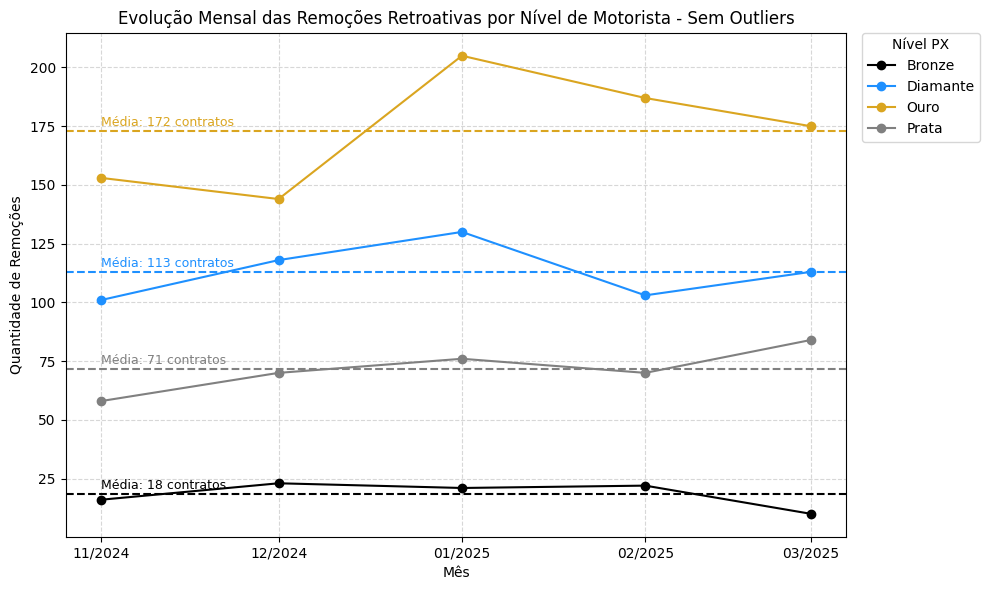

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot
plt.figure(figsize=(10, 6))

cores_nivel = {
    'Bronze': 'black',
    'Prata': '#808080',       # cinza claro (prata)
    'Ouro': '#DAA520',        # dourado
    'Diamante': '#1E90FF'     # azul forte
}

for nivel in serie_nivel.columns:
    # Linha de evolução
    plt.plot(serie_nivel.index, serie_nivel[nivel], marker='o', label=nivel, color=cores_nivel.get(nivel, 'black'))
    
    # Média
    media = serie_nivel[nivel].mean()
    plt.axhline(y=media, linestyle='--', linewidth=1.5, color=cores_nivel.get(nivel, 'black'))
    
    # Texto da média
    primeira_data = serie_nivel.index.min()
    plt.text(primeira_data, media + 1, f'Média: {int(media)} contratos', color=cores_nivel.get(nivel, 'black'),
             va='bottom', ha='left', fontsize=9)

# Estética do gráfico
plt.title('Evolução Mensal das Remoções Retroativas por Nível de Motorista - Sem Outliers')
plt.xlabel('Mês')
plt.ylabel('Quantidade de Remoções')
plt.grid(True, linestyle='--', alpha=0.5)

# Eixo X formatado
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.xticks(rotation=0)

# Legenda fora do gráfico, à direita
plt.legend(title='Nível PX', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.show()


In [12]:
# Garantir que 'ano_mes' seja datetime
df_original['ano_mes'] = pd.to_datetime(df_original['ano_mes'])

# Filtrar contratos com remoção
df_removidos = df_original[df_original['dias_reducao'] > 0].copy()

# Criar categoria de dias removidos
df_removidos['categoria_dias'] = pd.cut(
    df_removidos['dias_reducao'],
    bins=[0, 1, 2, 3, 4, float('inf')],
    labels=['1 dia', '2 dias', '3 dias', '4 dias', '5 ou mais']
)

# Agrupar por mês, tipo, tier e categoria de dias
grupo_mensal = (
    df_removidos
    .groupby(['ano_mes', 'tipo', 'nivel_px', 'categoria_dias'])
    .size()
    .reset_index(name='qtd_mensal')
)

# Calcular média mensal por tipo, nível e categoria
media_mensal = (
    grupo_mensal
    .groupby(['tipo', 'nivel_px', 'categoria_dias'])['qtd_mensal']
    .mean()
    .round(0)
    .astype(int)
    .reset_index(name='media_mensal')
)

# Pivotar para visualização
pivot_media_mensal = media_mensal.pivot_table(
    index=['tipo', 'nivel_px'],
    columns='categoria_dias',
    values='media_mensal',
    fill_value=0
).astype(int).reset_index()

# Exibir tabela final
print("Média Mensal por Categoria de Dias Removidos:\n")
display(pivot_media_mensal)


Média Mensal por Categoria de Dias Removidos:



/tmp/ipykernel_318413/4030274566.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['ano_mes', 'tipo', 'nivel_px', 'categoria_dias'])
/tmp/ipykernel_318413/4030274566.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['tipo', 'nivel_px', 'categoria_dias'])['qtd_mensal']
/tmp/ipykernel_318413/4030274566.py:33: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_media_mensal = media_mensal.pivot_table(


categoria_dias,tipo,nivel_px,1 dia,2 dias,3 dias,4 dias,5 ou mais
0,Ajudante,Bronze,0,0,0,0,0
1,Ajudante,Diamante,0,0,0,0,0
2,Ajudante,Ouro,1,0,0,0,0
3,Ajudante,Prata,0,0,0,0,0
4,Coleta/Entrega,Bronze,2,2,1,1,1
5,Coleta/Entrega,Diamante,7,1,2,0,1
6,Coleta/Entrega,Ouro,15,4,3,3,6
7,Coleta/Entrega,Prata,7,3,1,1,2
8,Diária,Bronze,5,2,1,1,2
9,Diária,Diamante,35,21,9,9,27


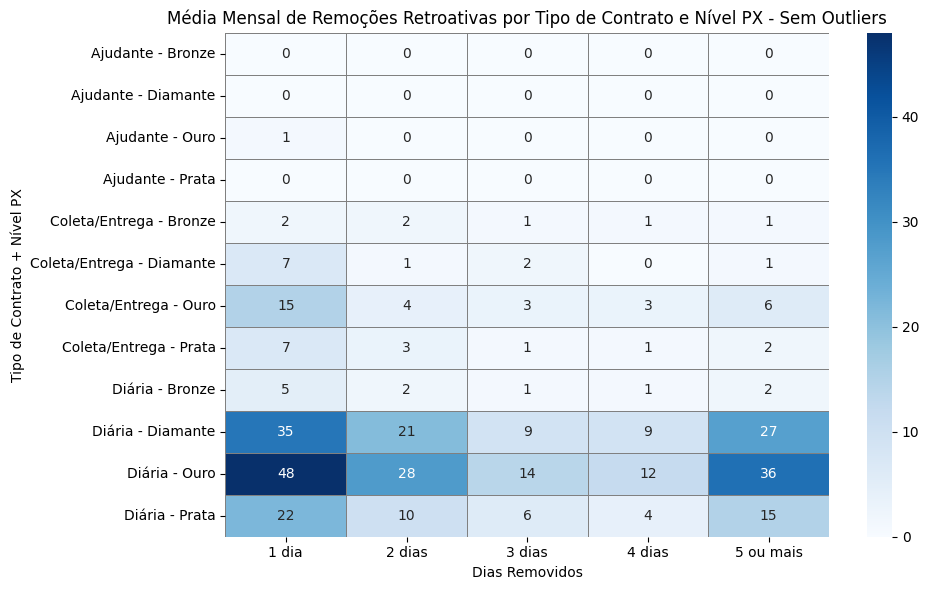

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Preparar dados
df_plot = pivot_media_mensal.copy()
df_plot['grupo'] = df_plot['tipo'] + ' - ' + df_plot['nivel_px']
df_plot = df_plot.set_index('grupo')[['1 dia', '2 dias', '3 dias', '4 dias', '5 ou mais']]

# Heatmap com nova paleta
plt.figure(figsize=(10, 6))
sns.heatmap(df_plot, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='gray')

plt.title('Média Mensal de Remoções Retroativas por Tipo de Contrato e Nível PX - Sem Outliers')
plt.xlabel('Dias Removidos')
plt.ylabel('Tipo de Contrato + Nível PX')
plt.tight_layout()
plt.show()



In [14]:
# Criar coluna binária: 1 se houve redução, 0 caso contrário
df_comparativo['flag_reducao'] = (df_comparativo['houve_reducao'] == 'sim').astype(int)

# Calcular proporção mensal por tipo, nivel_px e mês
mensal = df_comparativo.groupby(['ano_mes', 'tipo', 'nivel_px'])['flag_reducao'].mean().reset_index(name='proporcao_mensal')

# Calcular média da proporção ao longo dos meses por tipo e nivel_px
media_proporcao = mensal.groupby(['tipo', 'nivel_px'])['proporcao_mensal'].mean().round(3).reset_index(name='proporcao_media_mensal')
media_proporcao

,tipo,nivel_px,proporcao_media_mensal
0,Ajudante,Bronze,0.000
1,Ajudante,Diamante,0.015
2,Ajudante,Ouro,0.045
3,Ajudante,Prata,0.065
4,Coleta/Entrega,Bronze,0.076
5,Coleta/Entrega,Diamante,0.026
6,Coleta/Entrega,Ouro,0.040
7,Coleta/Entrega,Prata,0.064
8,Diária,Bronze,0.137
9,Diária,Diamante,0.101


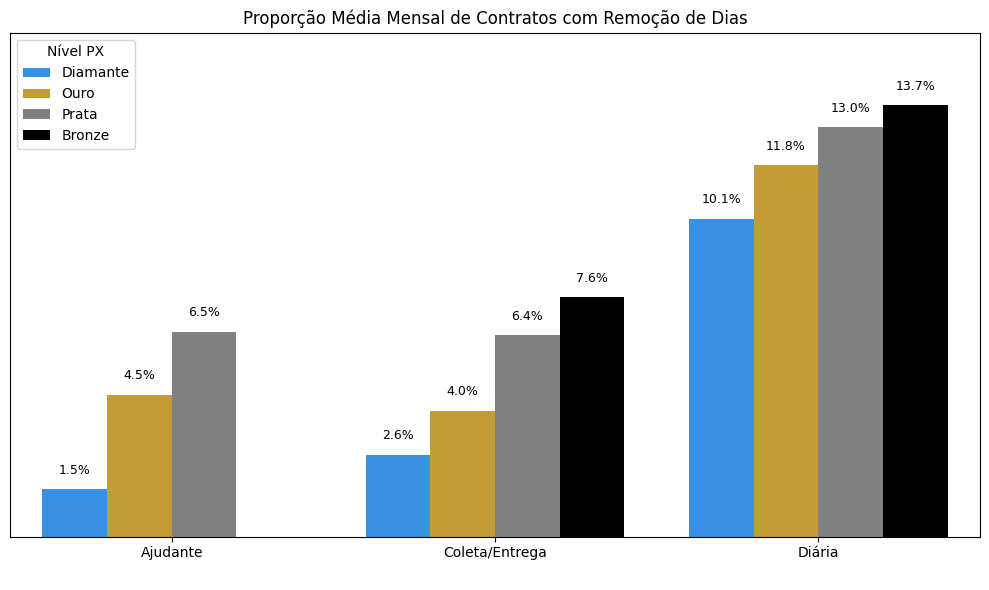

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir ordem personalizada dos níveis PX
ordem_niveis = ['Diamante', 'Ouro', 'Prata', 'Bronze']

# Garantir que 'nivel_px' é categórica com a ordem desejada
media_proporcao['nivel_px'] = pd.Categorical(media_proporcao['nivel_px'], categories=ordem_niveis, ordered=True)

# Paleta de cores com bom contraste
cores_nivel = {
    'Bronze': 'black',
    'Prata': '#808080',
    'Ouro': '#DAA520',
    'Diamante': '#1E90FF'
}

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=media_proporcao,
    x='tipo',
    y='proporcao_media_mensal',
    hue='nivel_px',
    hue_order=ordem_niveis,
    palette=cores_nivel
)

# Adicionar valores em % com 1 casa decimal acima das barras
for p in ax.patches:
    altura = p.get_height()
    if altura > 0:
        ax.text(
            p.get_x() + p.get_width() / 2,
            altura + 0.004,
            f'{altura * 100:.1f}%',
            ha='center',
            va='bottom',
            fontsize=9
        )

# Estética
plt.title('Proporção Média Mensal de Contratos com Remoção de Dias')
plt.xlabel(' ')
ax.set_ylabel('')  # Remover rótulo do eixo Y
ax.set_yticks([])  # Remover os valores do eixo Y
plt.ylim(0, 0.16)
plt.legend(title='Nível PX')
plt.grid(axis='y', linestyle='--', alpha=0.2)  # Mantém leve para alinhamento visual, opcional
plt.tight_layout()
plt.show()


